# Predicting Cat and Dog Adoptions at the AAC (Austin Animal Center)
***

# Table of Contents
***

## [Goals](#goals)

## [Acquire](#acquire)

## [Prepare](#prepare)

## [Explore](#explore)

## [Model](#model)

## [Conclusion](#conclusion)
<br>

# Goals <a id='goals'></a>
***

This project has 3 main goals
- create a model that will acurrately predict which cats and dogs will be adopted from the Austin Animal Center
- develop insights about what affects cat and dog adoptions
- develop insights about the activity at the AAC in general (when are intake counts high/low?, are there hotspots in Austin where strays can be found?, etc)

I will also deliver the following 
- aac_project_notebook.ipynb
    - This notebook which provides a start-to-finish walkthrough of the project
- README.md
    - A markdown file that provides various information about this project including a data dictionary, project plan, and a link to the source data
- wrangle.py
    - A file that contains all of the custom functions featured in this notebook
- A presentation of the project
    - A 3-5 minute presentation that summarizes the findings of this project (link to presentation slides below)
        - https://docs.google.com/presentation/d/1KTZ6N8kW-pXHV-GPKc_N_vQAmfRyqcuD25e6xDMk4mo/edit?usp=sharing

In [1]:
# establishing environment
import sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from wrangle import get_aac, prep_aac, wrangle_aac
from explore import rfe_ranker_lr, rfe_ranker_dtc, rfe_ranker_rf

from sklearn.feature_selection import RFE


# Acquire<a id='acquire'></a>
I'll begin by acquiring the data from a local CSV file. The data I'm using can be accessed via a link in the README file of this repository.
***

In [2]:
# reading data in as DF
df = get_aac()

# previewing data
df.head()

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,...,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194
1,7 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,...,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722
2,6 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,...,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889
3,10 years,A047759,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,...,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139
4,16 years,A134067,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,...,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444


### Acquire Takeaways
- Acquired data from local csv file using pandas __read_csv__ function
- Data can also be acquired via the __wrangle_aac__ function in the __wrangle.py__ file
    - Note that the __wrangle_aac__ function will also prep the data for exploration

# Prepare<a id='prepare'></a>
I'm now going to prepare the data for exploration.
***

In [3]:
# previewing data for null value counts and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79672 entries, 0 to 79671
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age_upon_outcome            79672 non-null  object 
 1   animal_id_outcome           79672 non-null  object 
 2   date_of_birth               79672 non-null  object 
 3   outcome_subtype             36348 non-null  object 
 4   outcome_type                79662 non-null  object 
 5   sex_upon_outcome            79671 non-null  object 
 6   age_upon_outcome_(days)     79672 non-null  int64  
 7   age_upon_outcome_(years)    79672 non-null  float64
 8   age_upon_outcome_age_group  79672 non-null  object 
 9   outcome_datetime            79672 non-null  object 
 10  outcome_month               79672 non-null  int64  
 11  outcome_year                79672 non-null  int64  
 12  outcome_monthyear           79672 non-null  object 
 13  outcome_weekday             796

### Prepping Data via prep_aac function

In [4]:
# prepping data with changes outlined in prepare takeaway section (below)
train, validate, test = prep_aac(df)

In [5]:
train.columns

Index(['perceived_agg_breed', 'is_cat', 'is_dog', 'species', 'is_male',
       'is_female', 'gender_unknown', 'gender', 'sterilized_income',
       'outcome_subtype', 'outcome_type', 'age_group_years',
       'age_outcome_days', 'intake_weekday', 'intake_month', 'intake_year',
       'intake_type', 'is_euthanasia_request', 'is_owner_surrender',
       'is_public_assist', 'is_stray', 'is_wildlife', 'intake_condition',
       'is_aged', 'is_feral', 'is_injured', 'is_normal', 'is_nursing',
       'is_other', 'is_pregnant', 'is_sick', 'age_outcome_days_s',
       'is_adopted'],
      dtype='object')

In [6]:
# previewing train df
train.head()

,perceived_agg_breed,is_cat,is_dog,species,is_male,is_female,gender_unknown,gender,sterilized_income,outcome_subtype,...,is_aged,is_feral,is_injured,is_normal,is_nursing,is_other,is_pregnant,is_sick,age_outcome_days_s,is_adopted
41664,0,0,1,dog,1,0,0,Male,1,unknown,...,0,0,0,1,0,0,0,0,0.008219,1
8001,1,0,1,dog,1,0,0,Male,1,Partner,...,0,0,0,1,0,0,0,0,0.050000,0
70226,0,0,1,dog,0,1,0,Female,0,unknown,...,0,0,0,1,0,0,0,0,0.100000,1
70696,0,1,0,cat,0,1,0,Female,0,Foster,...,0,0,0,1,0,0,0,0,0.012329,1
39646,0,1,0,cat,1,0,0,Male,0,Partner,...,0,0,0,1,0,0,0,0,0.002877,0


### Prepare Takeaways
After reviewing the data for this project, I elected to make the following changes by creating a function, __prep_aac__, located in the __wrangle.py file__. 

Alternatively, the __wrangle_aac__ function from the __wrangle.py file__ can be ran to both acquire and prep the data with a single function.

- __Dropped columns that will not be used in this iteration but may be explored in a future iteration as this is an ongoing project__
    - animal_id_outcome | animal_id_intake | outcome_number | intake_number
        - Could prove useful in allowing me to track animals that visit the AAC multiple times
    - outcome_datetime | outcome_month | outcome_year | outcome_monthyear | outcome_weekday | outcome_hour
        - Would be interesting to see if there are time periods when adoptions spike / dip
    - age_upon_intake_(days) |found_location | intake_condition | intake_type | intake_datetime | time_in_shelter_days
        - Do these variables correlate with any other features or outcomes? 
    - color
        - Are some color / animal combinations adopted more often?
        
        
- __Dropped columns that were not needed since the value of their information can be derived from other columns__
    - date_of_birth | age_upon_outcome | age_upon_outcome_(years) | age_upon_outcome_age_group | dob_year | dob_month | dob_monthyear | age_upon_intake_(years) | age_upon_intake | age_upon_intake_age_group |  intake_month | intake_year | intake_monthyear | intake_weekday | intake_hour | time_in_shelter | age_group_year 


- __Other changes__
- Dropped "count" column
    - created by uploader of data to Kaggle, not useful for this project
- Renamed age_upon_outcome_(days) to age_outcome_days
- Renamed animal_type to species
- Created "perceived_agg_breed" column that reflects if animal is of breed that is commonly perceived as aggressive (chow, doberman, pitbull, rottweiler)
- Created scaled versions of age_outcome_days column, age_outcome_days_s
- Added age_group_years columns, holds binned values of age in years
- Converted sex_upon_outcome into gender column and created boolean columns for each value within it (male, female, unknown)
    - sex_upon_outcome also contains information about the sterilization status of an animal at the time of outcome but i did not create a column for this data
        - Per the AAC, if an animal wasn't sterilized prior to entering the AAC, they can only be sterilized at the adopters discression upon adoption
        - Thus the AAC wouldn't have the information available to use sterilization status at outcome feature prior prior to animal's adoption.
        - That being said, I'm excluding it as a feature in this project since my goal is to create a model that the AAC could use in a real-world setting
- Added boolean columns for animal types dog and cat
- Added boolean columns for all intake_condition and intake_type values
- Transformed outcome_type to binary categorical column 'is_adopted' 
- Dropped all animals that were not cats or dogs to simplify scope of project and save time
    - Will explore alternate species in next iteration of project
- Dropped rows with outcome type that indicated animal was returned to owner
- Dropped rows with outcome type of "disposal"
    - Rows represent animals that were deceased prior to arrival at AAC, no chance of adoption
- Dropped null values
    - Very few nulls so dropping won't have a meaningful impact
- Split data into train, validate, and test sets

# Explore<a id='explore'></a>
I'm going to explore the data using plots and hypothesis tests to identify viable features for predicting adoption.
***

## Variable to Explore: Age
Is there a connection between age and adoption? I suspect that older animals are adopted less often.

### Visualization

In [7]:
# setting figure and text size for all plots
sns.set(rc = {'figure.figsize':(12,6)})
sns.set(font_scale = 2)

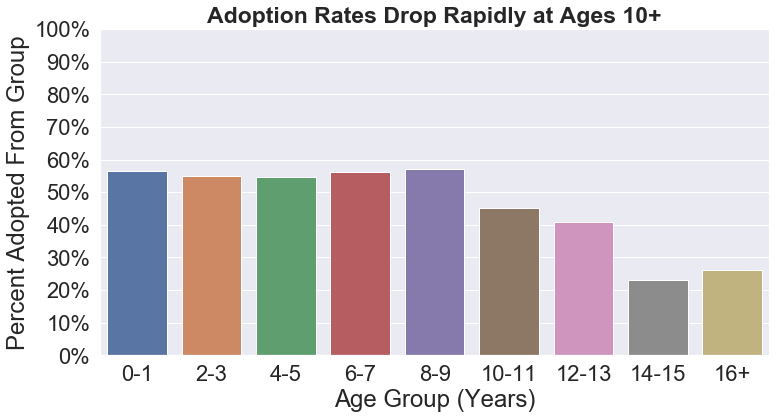

In [8]:
# grouping by age groups (years) and aggregating average % of adopted animals within each group
# sorting by age groups
age_group_adopts = train.groupby('age_group_years').mean()[['is_adopted']].sort_values('age_group_years')

# relabeling index to make x axis ticks simpler
age_group_adopts.index = ['0-1', '2-3', '4-5', '6-7', '8-9', '10-11', '12-13', '14-15', '16+']

# creating plot
sns.barplot(data=age_group_adopts, x=age_group_adopts.index, y='is_adopted')
plt.xlabel("Age Group (Years)")
plt.ylabel("Percent Adopted From Group")
plt.title("Adoption Rates Drop Rapidly at Ages 10+", fontweight='bold', fontsize=23)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.yticks(np.linspace(0, 1, 11), labels=fmt)
plt.show()

### Average % of animals 0 to 9 years old that get adopted?

In [9]:
round(train.groupby('age_group_years').mean()['is_adopted'][0:5].mean(),2)

0.56

### Average % of animals 10 to 16 years old that get adopted?

In [10]:
round(train.groupby('age_group_years').mean()['is_adopted'][5:9].mean(),2)

0.34

### Average % of animals 15+ years old that get adopted?

In [11]:
round(train.groupby('age_group_years').mean()['is_adopted'][7:].mean(),2)

0.25

- Adoption rates between animals ages 0-9 years of age are fairly close


- From age 10 onward, adoption rates drop rapidly


- The age 16+ age group has roughly half the adoption rate of the 0-1 age group

## Two-sample one-tailed t-test
### Hypotheses
<br>
H0: The average age of animals who are adopted is equal to or greater than the average of animals that are not adopted
<br>
Ha: The average age of animals who are adopted is less than the average of animals that are not adopted

In [12]:
# x1 = series of ages of animals who were adopted
# x2 = series of ages of animals who were not adopted
x1 = train[train.is_adopted == 1]['age_outcome_days']
x2 = train[train.is_adopted == 0]['age_outcome_days']

# performing t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p/2}')
print (f't =',t)

alpha = .05

p = 3.656889348128875e-11
t = -6.516184837764797


- Since p is less than alpha and t is negative I reject the null hypothesis


- The t-test results and visual are both evidence that younger animals are favored over elderly animals for adoption

- I may use this variable as a feature in modeling

## Variable to Explore: Species
In terms of percent, is one species adopted more often that the other?

### Comparing adoption rates: cats vs. dogs

In [13]:
# using groupby to examine adoption rates within species
cat_v_dog = train.groupby('species').mean()[['is_adopted']]

cat_v_dog

,is_adopted
species,
cat,0.455803
dog,0.644075


- 45% of all cats are adopted


- 64% of all dogs are adopted

### Visualization

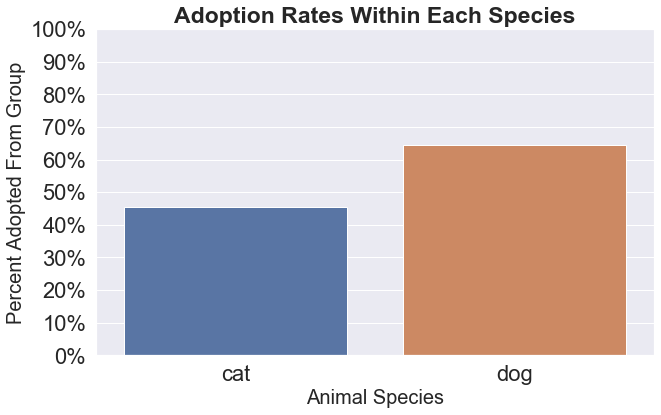

In [14]:
# grouping by species and aggregating % of each species that are adopted
type_adopt = train.groupby('species').mean()[['is_adopted']].sort_values('species')

# creating plot
plt.figure(figsize=(10, 6))
sns.barplot(data = type_adopt, x = type_adopt.index, y='is_adopted')
plt.xlabel("Animal Species", fontsize= 20)
plt.ylabel("Percent Adopted From Group", fontsize= 20)
plt.title("Adoption Rates Within Each Species", fontweight='bold', fontsize=23)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.yticks(np.linspace(0, 1, 11), labels=fmt)
plt.show()

- ~60% of all dogs are adopted
- ~45% of all cats are adopted

- This __does not__ mean that more dogs are adopted than cats

- It __does mean__ that the data reflects that among all dogs, roughly 60% of them are adopted whereas among all cats, 45% of them are adopted

### Chi-Squared Test

### Hypotheses
<br>
H0: Adoption and animal type are independent
<br>
Ha: Adoption and animal type are dependent

In [15]:
# creating crosstab of cat adoptions vs dog adoptions
ct_species = pd.crosstab(train.species, train.is_adopted)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_species)

# printing results
print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.0000


- Since p is less than alpha, I am rejecting the null hypothesis that adopation and animal type are independent


- Given results of the hypothesis test and visualization, I may use this variable as a feature in modeling

## Variable to Explore: Gender

### Identifying # of unknown gender animals

In [16]:
# using groupby to examine adoption rates within each gender value
male_v_female = train.groupby('gender').mean()[['is_adopted']]

male_v_female

,is_adopted
gender,
Female,0.585855
Male,0.580576
Unknown,0.000000


### Checking total number of cats and dogs with no gender

In [17]:
train[train.gender == 'Unknown'].shape[0]

1559

### Researching unknown gender cats and dogs in depth
Very peculiar that 0 out nearly 1600 were not adopted

In [18]:
train[train.gender == 'Unknown']['outcome_type'].value_counts()

Transfer      1358
Euthanasia     157
Died            44
Name: outcome_type, dtype: int64

In [19]:
train[train.gender == 'Unknown']['outcome_subtype'].value_counts()

Partner        1052
SCRP            244
Suffering       134
Snr              62
In Kennel        28
At Vet           10
In Foster         7
Rabies Risk       6
Medical           6
unknown           5
Enroute           3
Aggressive        1
Underage          1
Name: outcome_subtype, dtype: int64

- All the unknown gender cats and dogs that were not adopted were either transfered, put down, or passed away

### Visualization

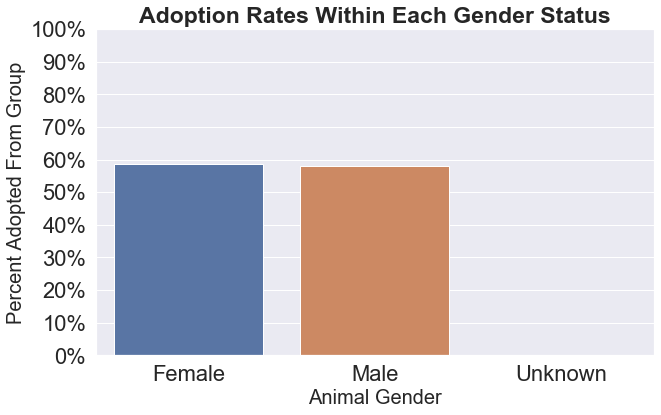

In [20]:
# grouping by gender and aggregating % of adoptions within each gender value
gender_adopt = train.groupby('gender').mean()[['is_adopted']].sort_values('gender')

# plotting 
plt.figure(figsize=(10, 6))
sns.barplot(data = gender_adopt, x = gender_adopt.index, y='is_adopted')
plt.xlabel("Animal Gender", fontsize= 20)
plt.ylabel("Percent Adopted From Group", fontsize= 20)
plt.title("Adoption Rates Within Each Gender Status", fontweight='bold', fontsize=23)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.yticks(np.linspace(0, 1, 11), labels=fmt)
plt.show()

- __The figures below indicate what % of each gender group are adopted, not the percent of adoptions that belong to each gender group__


- Females
    - 58% of all male animals are adopted
    
    
- Males
    - 58% of all female animals are adopted
    
    
- Unknown gender
    - 0 out of 1559 unknown gender animals are adopted
    - All the unknown gender cats and dogs that were not adopted were either transfered, put down, or passed away

### Chi-Squared Test

### Hypotheses
<br>
H0: Adoption and gender (including unknown gender) are independent
<br>
Ha: Adoption and gender (including unknown gender) are dependent

In [21]:
# creating crosstab of male, female and gender unknown adoptions
ct_gender = pd.crosstab(train.gender, train.is_adopted)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_gender)

# printing results
print('alpha = .05\n')
print(f'p     = {p:.4f}')

alpha = .05

p     = 0.0000


- Since p is less than alpha, I am rejecting the null hypothesis that adoption and gender (including unknown gender) are independent


- I suspect that the unknown gender values are responsible for the low p value so I'm going to conduct this test again without them

### Chi-Squared Test
### Hypotheses
<br>
H0: Adoption and gender (not including unknown gender) are independent
<br>
Ha: Adoption and gender (not including unknown gender) are dependent

In [22]:
# creating df that only includes rows with animals of identified gender
fm = train[train.gender != "Unknown"]

# creating crosstab using gender and is_adopted columns
ct_fm = pd.crosstab(fm.gender, fm.is_adopted)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_fm)

# printing results
print('alpha = .05\n')
print(f'p     = {p:.4f}')

alpha = .05

p     = 0.3439


- Since p is greater than alpha, I fail to reject the null hypothesis that adoption and gender are independent


- This makes sense given that adoption rates only significantly differ between known and unknown gender animals and not between the animals with identified genders (male and female)


- The percentages of adoption seen between genders and visualization suggest that gender only significantly impacts adoption if the animal's gender is unknown 


- I may use this variable as a feature in modeling

## Variable to Explore: Animal's Sterilization Status Prior to AAC
The AAC only sterilizes animals at the adopters requests upon adoption. Do animals that were sterilized (netured or spayed) prior to entering the AAC have higher rates of adoption?

In [23]:
# using groupby to examine adoption rates between 
# sterilized and unsterilized animals (prior to AAC)
income_ster = train.groupby('sterilized_income').mean()[['is_adopted']]

income_ster

,is_adopted
sterilized_income,
0,0.537124
1,0.615271


### Visualization

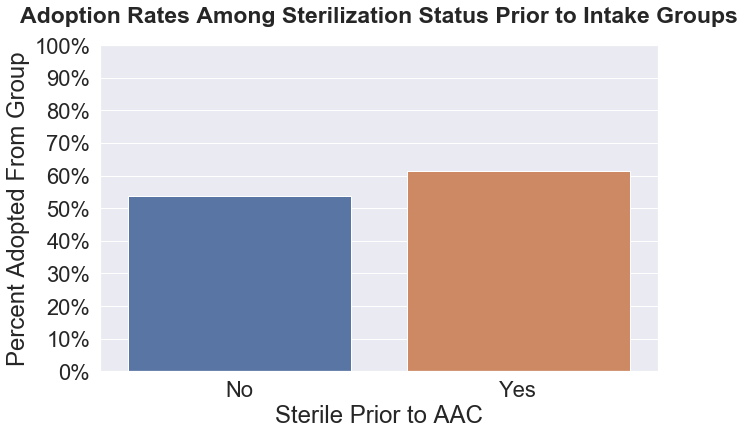

In [24]:
# grouping by sterilization status prior to AAC and aggregating % of adoptions
# within each status group
sterile_adopt = train.groupby('sterilized_income').mean()[['is_adopted']].sort_values('sterilized_income')

# changing index values to no and yes from 0 and 1, respectively
sterile_adopt.index = ['No', 'Yes']

# creating plot
plt.figure(figsize=(10, 6))
sns.barplot(data = sterile_adopt, x = sterile_adopt.index, y='is_adopted')
plt.xlabel("Sterile Prior to AAC")
plt.ylabel("Percent Adopted From Group")
plt.title("Adoption Rates Among Sterilization Status Prior to Intake Groups", fontweight='bold', fontsize=23, y=1.05)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.yticks(np.linspace(0, 1, 11), labels=fmt)
plt.show()

- ~61% of animals that are sterilized prior the AAC are adopted
- ~52% of animals that are not sterilized prior the AAC are adoptedm

## Chi Squared Test
### Hypotheses
<br>
H0: sterilized_income and adoption are independent
<br>
Ha: sterilized_income and adoption are dependent

In [25]:
# creating crosstab using sterilization prior to AAC and is_adopted columns
observed_sterile = pd.crosstab(train.sterilized_income, train.is_adopted)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(observed_sterile)

# printing results
print('alpha = .05\n')
print(f'p     = {p:.4f}')

alpha = .05

p     = 0.0000


- Since p is less than alpha, I reject the null hypothesis that income_sterilization and gender are independent


- The calculated percentages and visualization indicate that animals that a higher percent of animals sterilized prior to the AAC are adopted than those were not sterilized prior to the AAC


- This __does not__ mean that animals sterilized prior to the AAC are adopted more often overall


- It __does mean__ that the data reflects that 
    - among all dogs and cats sterilized before the AAC, roughly 61% were adopted
    - among all dogs and cats not sterilized before the AAC, roughly 52% were adopted


## Feature to Explore: Breeds that are commonly perceived as aggressive
Many people believe that there are "agressive" breeds of dogs. Dogs of these breeds may have a harder time getting adopted (Pit Bull, Rottweiler, Chow, Doberman).

In [26]:
# filtering for only rows that include dogs
dogs = train[train.species == 'dog']

# using groupby to examine adoption rates within species
agg = dogs.groupby('perceived_agg_breed').mean()[['is_adopted']]

agg

,is_adopted
perceived_agg_breed,
0,0.660154
1,0.565603


### Visualization

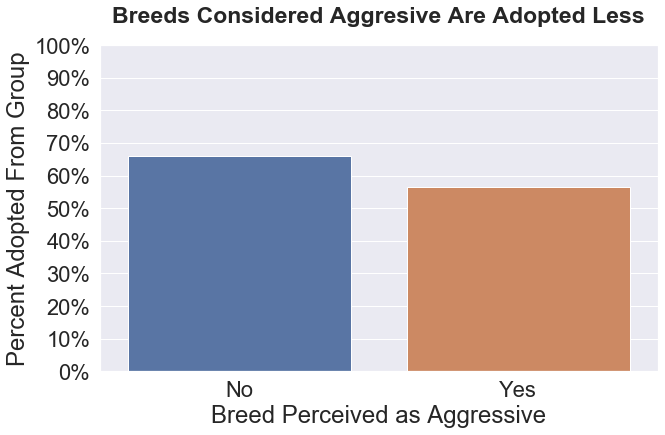

In [27]:
# changing index to no and yes from 0 and 1, respectively
agg.index = (['No', 'Yes'])

# creating plot
plt.figure(figsize=(10, 6))
sns.barplot(data=agg, x=agg.index, y='is_adopted')
plt.xlabel("Breed Perceived as Aggressive")
plt.ylabel("Percent Adopted From Group")
plt.title("Breeds Considered Aggresive Are Adopted Less", fontweight='bold', fontsize=23,y = 1.05)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.yticks(np.linspace(0, 1, 11), labels=fmt)
plt.show()

- This __does not__ mean that dogs that are of a breed that is perceived to be aggressive are adopted less often overall


- It __does mean__ that the data reflects that 
    - among all dogs that are of a breed that is perceived to be aggressive, 58% are adopted
    - among all dogs that are of a breed that is not perceived to be aggressive, 68% are adopted

### Chi-Squared Test

### Hypotheses
<br>
H0: Adoption and whether an animal is neutered of spayed are independent
<br>
Ha: Adoption and whether an animal is neutered of spayed are dependent

In [28]:
# creating crosstab using agg_breed and is_adopted columns
ct_breed = pd.crosstab(dogs.perceived_agg_breed, dogs.is_adopted)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_breed)

# printing results
print('alpha = .05\n')
print(f'p     = {p:.4f}')

alpha = .05

p     = 0.0000


- Since p is less than alpha I am rejecting the null hypothesis that dog breeds perceived as aggressive and adoption are independent


- Given the visualization and hypothesis test results, I may use perceived_agg_breed as a model feature

## Feature to Explore: Intake Condition
Does the condition of an animal at intake affect it's chance of adoption?

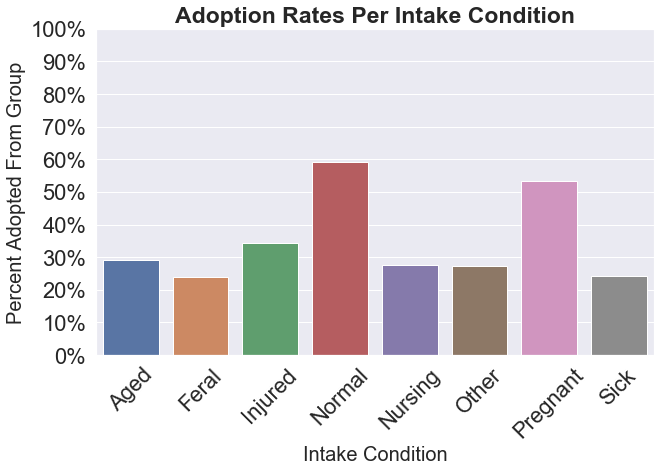

In [29]:
# grouping by intake condition and aggregating % of adoptions within each intake condition value
intake_con_adopt = train.groupby('intake_condition').mean()[['is_adopted']].sort_values('intake_condition')

# plotting 
plt.figure(figsize=(10, 6))
sns.barplot(data = intake_con_adopt, x = intake_con_adopt.index, y='is_adopted')
plt.xlabel("Intake Condition", fontsize= 20)
plt.ylabel("Percent Adopted From Group", fontsize= 20)
plt.title("Adoption Rates Per Intake Condition", fontweight='bold', fontsize=23)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.xticks(rotation=45) 
plt.yticks(np.linspace(0, 1, 11), labels=fmt)


plt.show()

- __These figures do not indicate that more animals that are normal or pregnant at intake are adopted more than others__


- __These figures only indicate the adoption rates within each intake condition group__
    - For example, the visual indicates that ~60% of all normal-at-intake animals are adopted, not that ~60% of all adoptions are normal at intake.
   
    
- ~60% of all cats and dogs that are normal at intake are adopted
- ~52% of all cats and dogs that are pregnant at intake are adopted
- All other cats and dogs are adopted at lower rates within their own intake condition groups

### Chi-Squared Test
### Hypotheses
<br>
H0: Adoption and intake condition are independent
<br>
Ha: Adoption and intake condition are dependent

In [30]:
# creating crosstab using intake_condition and is_adopted columns
ct_ic = pd.crosstab(train.intake_condition, train.is_adopted)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_ic)

# printing results
print('alpha = .05\n')
print(f'p     = {p:.4f}')

alpha = .05

p     = 0.0000


- Since p is less than alpha I am rejecting the null hypothesis that dogs of a breed that intake condtion and adoption are independent


- Given the visualization and hypothesis test results, I may use intake_condition as a model feature

## Feature to Explore: Intake Type
Does the condition of an animal at intake affect it's chance of adoption?

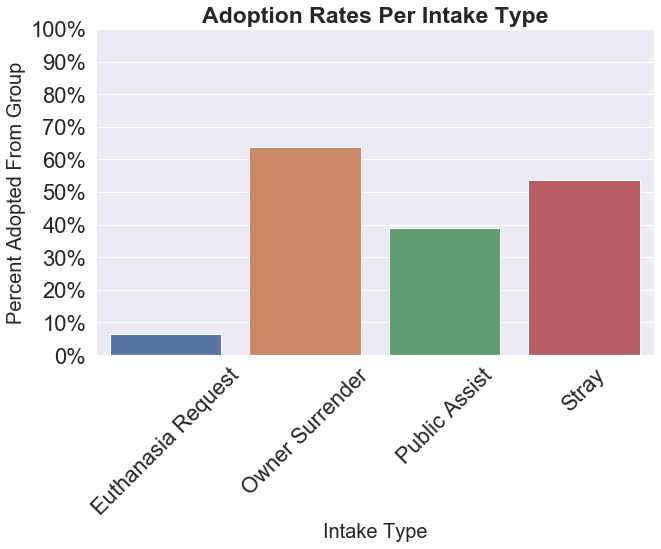

In [31]:
# grouping by intake type and aggregating % of adoptions within each intake type value
intake_type_adopt = train.groupby('intake_type').mean()[['is_adopted']].sort_values('intake_type')

# plotting 
plt.figure(figsize=(10, 6))
sns.barplot(data = intake_type_adopt, x = intake_type_adopt.index, y='is_adopted')
plt.xlabel("Intake Type", fontsize= 20)
plt.ylabel("Percent Adopted From Group", fontsize= 20)
plt.title("Adoption Rates Per Intake Type", fontweight='bold', fontsize=23)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.xticks(rotation=45) 
plt.yticks(np.linspace(0, 1, 11), labels=fmt)

plt.show()

- __These figures do not indicate that more animals that were surrendered by their owner are adopted more than others__


- __These figures indicate the adoption rates within each intake type group__
    - For example, the visual indicates that ~62% of all cat and dogs surrendered by their owner are adopted, not that ~62% of all adopted animals were surrendered by their owner.
   
    
- ~62% of all cats and dogs that were surrendered by their owner are adopted
- ~52% of all cats and dogs that were strays are adopted
- All other cats and dogs are adopted at lower rates within their own intake type groups


### Chi-Squared Test
### Hypotheses
<br>
H0: Adoption and intake type are independent
<br>
Ha: Adoption and intake type are dependent

In [32]:
# creating crosstab using intake_type and is_adopted columns
ct_it = pd.crosstab(train.intake_type, train.is_adopted)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_it)

# printing results
print('alpha = .05\n')
print(f'p     = {p:.4f}')

alpha = .05

p     = 0.0000


- Since p is less than alpha I am rejecting the null hypothesis that dogs of a breed that intake type and adoption are independent


- Given the visualization and hypothesis test results, I may use intake_type as a model feature


## Feature Selection

### Using rfe_ranker_lr (explore.py) to identify impactful features for Logistic Regression Model

In [33]:
rfe_ranker_lr(train)

,Feature,Rank
5,gender_unknown,1
7,is_euthanasia_request,2
4,is_female,3
3,is_male,4
15,is_normal,5
20,age_outcome_days_s,6
8,is_owner_surrender,7
10,is_stray,8
1,is_cat,9
18,is_pregnant,10


### Using rfe_ranker_rf (explore.py) to identify impactful features for Random Forest Model

In [34]:
rfe_ranker_rf(train)

,Feature,Rank
20,age_outcome_days_s,1
5,gender_unknown,2
15,is_normal,3
2,is_dog,4
1,is_cat,5
19,is_sick,6
8,is_owner_surrender,7
10,is_stray,8
14,is_injured,9
16,is_nursing,10


### Using rfe_ranker_dtc (explore.py) to identify impactful features for Decision Tree Model

In [35]:
rfe_ranker_dtc(train)

,Feature,Rank
20,age_outcome_days_s,1
15,is_normal,2
5,gender_unknown,3
16,is_nursing,4
6,sterilized_income,5
19,is_sick,6
18,is_pregnant,7
17,is_other,8
14,is_injured,9
13,is_feral,10


### Exploration Takeaways
- Some visualizations showed slight to stark differences between cats and dogs with varying characteristics whereas others did not 


- Two-sample, one-tailed t-test suggested that the average age of adopted animals is lower than the average age of animals that are not adopted


- Chi square tests showed that is_adopted and all of the following variables are not independent of each other
    - animal_type (cat or dog)
    - gender (male, female, unknown)
    - agg_breed (if a breed of dog is commonly perceived as aggressive)
    - sterilized_income (if an animal was sterilized prior to entering the AAC)
    - intake_condition
    
    
- Used Recursive Feature Elimination (RFE) to identify the most impactful features for logistic regrssion, decision tree, and random forest models

# Model<a id='model'></a>
I'll now create several models that will predict whether an animal was adopted based on it's various features.
***

## Baseline

In [36]:
# checking most common value of target variable
# ie. are animals more adopted more often than not?
train.is_adopted.value_counts()

1    18670
0    14904
Name: is_adopted, dtype: int64

In [37]:
# setting baseline prediction to 1
train['baseline_pred'] = 1

In [38]:
# printing performance metrics
print(classification_report(train.is_adopted, train.baseline_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14904
           1       0.56      1.00      0.71     18670

    accuracy                           0.56     33574
   macro avg       0.28      0.50      0.36     33574
weighted avg       0.31      0.56      0.40     33574



## Train

In [39]:
# setting target variable
y_train = train['is_adopted']

### Model 1 - Logistic Regression

In [40]:
# setting feature for model
X_train_m1 = train[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating logistic regression object
lr = LogisticRegression(random_state=123)

# fitting model to data
lr.fit(X_train_m1, y_train)

# creating column with model predictions
train['m1_prediction'] = lr.predict(X_train_m1)

# printing performance metrics
print(classification_report(train.is_adopted, train.m1_prediction))

              precision    recall  f1-score   support

           0       0.74      0.30      0.43     14904
           1       0.62      0.91      0.74     18670

    accuracy                           0.64     33574
   macro avg       0.68      0.61      0.58     33574
weighted avg       0.67      0.64      0.60     33574



### Model 2 - Random Forest

In [41]:
# creating DF with selected features for logistic regression model
X_train_m2 = train[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating random forest object
rf = RandomForestClassifier(max_depth = 3, random_state=123)

# fitting to data
rf.fit(X_train_m2, y_train)

# making predictions
train['m2_prediction'] = rf.predict(X_train_m2)

# printing performance metrics
print(classification_report(train.is_adopted, train.m2_prediction))

              precision    recall  f1-score   support

           0       1.00      0.24      0.39     14904
           1       0.62      1.00      0.77     18670

    accuracy                           0.66     33574
   macro avg       0.81      0.62      0.58     33574
weighted avg       0.79      0.66      0.60     33574



### Model 3 - Decision Tree

In [42]:
# creating DF with selected features for decision tree model
X_train_m3 = train[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating decision tree object
dtree = DecisionTreeClassifier(max_depth = 3, random_state=123)

# fitting d tree to data
dtree.fit(X_train_m3, y_train)

# predicting values
train['m3_prediction'] = dtree.predict(X_train_m3)

# printing performance metrics
print(classification_report(train.is_adopted, train.m3_prediction))

              precision    recall  f1-score   support

           0       1.00      0.24      0.39     14904
           1       0.62      1.00      0.77     18670

    accuracy                           0.66     33574
   macro avg       0.81      0.62      0.58     33574
weighted avg       0.79      0.66      0.60     33574



### Model 4 - Knearest Neighbor

In [43]:
# creating DF with selected features for KNN model
X_train_m4 = train[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating KNN object
knn = KNeighborsClassifier(n_neighbors=2, weights = 'uniform')

# fitting model to data
knn.fit(X_train_m4, y_train)

# making predictions on x train
m4_y_pred = pd.DataFrame(knn.predict(X_train_m4))

# creating column with model predictions
train['m4_prediction'] = knn.predict(X_train_m4)

# printing performance metrics
print(classification_report(train.is_adopted, train.m4_prediction))

              precision    recall  f1-score   support

           0       0.49      0.79      0.60     14904
           1       0.67      0.33      0.45     18670

    accuracy                           0.54     33574
   macro avg       0.58      0.56      0.52     33574
weighted avg       0.59      0.54      0.52     33574



- All models surpassed baseline's accuracy of 56%


- Top 2 models are random forest and decision tree
    - Model 2 - Random Forest Accuracy: 71%
    - Model 3 - Decision Tree Accuracy: 66%
    - Both will be used on the validate set

## Validate

In [44]:
# setting target variable
y_val = validate['is_adopted']

### Model 2 - Random Forest

In [45]:
# setting features for model
X_val_m2 = validate[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating column with model predictions
validate['m2_prediction'] = rf.predict(X_val_m2)

# printing performance metrics
print(classification_report(validate.is_adopted, validate.m2_prediction))

              precision    recall  f1-score   support

           0       1.00      0.24      0.38      6318
           1       0.63      1.00      0.77      8071

    accuracy                           0.66     14389
   macro avg       0.81      0.62      0.58     14389
weighted avg       0.79      0.66      0.60     14389



### Model 3 - Decision Tree

In [46]:
# setting features for model
X_val_m3 = validate[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating column with model predictions
validate['m3_prediction'] = dtree.predict(X_val_m3)

# printing performance metrics
print(classification_report(validate.is_adopted, validate.m3_prediction))

              precision    recall  f1-score   support

           0       1.00      0.24      0.38      6318
           1       0.63      1.00      0.77      8071

    accuracy                           0.66     14389
   macro avg       0.81      0.62      0.58     14389
weighted avg       0.79      0.66      0.60     14389



- Random Forest accuracy on validation set: 70%


- Decision Tree accuracy on validation set: 66%


- Given its better accuracy on validate set, the random forest model will be used on test



## Test

### Model 2 - Random Forest

In [47]:
# setting target variable
y_test = test['is_adopted']

# setting features for model
X_test_m2 = test[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating column with model predictions
test['m2_prediction'] = rf.predict(X_test_m2)

# printing performance metrics
print(classification_report(test.is_adopted, test.m2_prediction))

              precision    recall  f1-score   support

           0       1.00      0.24      0.38      5476
           1       0.61      1.00      0.76      6515

    accuracy                           0.65     11991
   macro avg       0.80      0.62      0.57     11991
weighted avg       0.79      0.65      0.59     11991



- Random forest model produced performed with 70% accuracy on test data

- Average accuracy on out-of-sample data, 70%

### Modeling Takeaways

- Created models using the following algorithms 
    - logistic regression
    - random forest
    - k-nearest neighbor
    - decision tree


- __Train Set Model Performances__
    - Logistic Regression
        - Accuracy: 64%
    - Random Forest
        - Accuracy: 71%
    - Decision Tree 
        - Accuracy: 66%
    - K-Nearest Neighbor
        - Accuracy: 54%
    
    
- __Validate Set Model Performances__
    - Random Forest 
        - Accuracy: 70%
    - Decision Tree 
        - Accuracy: 66%


- __Test Set Model Performance__
    - Random Forest 
        - Accuracy on in-sample (seen) data: 71%
        - Average accuracy on out-of-sample (unseen) data: 70%
       

# Conclusion<a id='conclusion'></a>

### Acquire
- Acquired data from local csv file

### Prepare
- Prepped data with various changes, namely:
    - Dropped columns for various reason
        - Some will be restored and explore in a future iteration of this project
    - Split column that contained gender and sterilization at time of intake information
    - Added boolean columns for categorical data
    - Renamed columns
    - Dropped null values
    - Split Data
    
### Explore
- Some visualizations showed slight to stark differences between cats and dogs with varying characteristics whereas others did not 


- Two-sample, one-tailed t-test suggested that the average age of adopted animals is lower than the average age of animals that are not adopted


- Chi square tests showed that is_adopted and all of the following variables are not independent of each other
    - animal_type (cat or dog)
    - gender (male, female, unknown)
    - agg_breed (if a breed of dog is commonly perceived as aggressive)
    - sterilized_income (if an animal was sterilized prior to entering the AAC)
    - intake_condition
    - intake_type
    
### Model
- Created baseline model that produced 56% accuracy on train data
- Created 4 alternate models using various algorithms
- Best Model was created with the following profile
    - Type: Random Forest
    - Features: 
        - age_outcome_days_s (animal's age)
        - is_dog (represents if animal is a dog)
        - gender_unknown (if animal's gender is unknown)
        - sterilized_income (if animal was sterile at time of intake into AAC)
        - perceived_agg_breed (if animal's breed is commonly perceived as aggressive)
- Peformed with 71% accuracy on train (in-sample) data
- Peformed with 70% accuracy on validatea and test (out-of-sample) data

### Recommendations
- Develop a program that aims to pair older animals with suitable homes
- Sterilize animals prior to adoption
- Use website and promotional material to advocate for increased cat adoption

### Predictions
- By following the recommendations above, the AAC may be able to increase their adoption rates

### Plans for the future
- I'd like to explore the features that I was not able to explore in this iteration of the project in the interest of time.